# Run python script for wind field generation (will be put on pypi in following version)

In [64]:
run ../pyforwind/pyforwind.py

# Set the wind field box 

In [77]:
N_x = 2048 # grid points in "temporal" direction
N_y = N_z = 21 # rotor plane
N_xi = 30 # number of realization in Gaussian scale mixture 
dy = dz = 10 # resolution in rotor plane
y_i = z_i = -100. # lower left point of grid in rotor plane
y_e = z_e = 100. # upper right point of grid in rotor plane

# Model parameters

In [100]:
H=1./3. # Hurst exponent, determines power law of Kaimal spectrum
mu=0.32 # intermittency coefficient
eta=dy 
L=420. # integral length scale in Kaimal spectrum
L_c=120. # correlation length in Kaimal coherences
T=600. # length of time series
tilde_T=1200.
V_hub=8.164

In [101]:
swf = SWF(H, L, L_c, mu, dy, dz, y_i, y_e, z_i, z_e, T, tilde_T, N_x, N_y, N_z, N_xi, V_hub)
for nn in range(1):
    seed = 97 #np.random.randint(100)
    u, mask = swf.field(seed)
    u /= np.std(u)
    u_gauss = swf.gauss_field(seed)
    u_gauss /= np.std(u_gauss)

xi_values 0.330556614201788
xi_values 0.4626765761701937
xi_values 0.4648351505629279
xi_values 0.4651840438991127
xi_values 0.49153566531797405
xi_values 0.5429706285334958
xi_values 0.7079408793353549
xi_values 0.7244087259334921
xi_values 0.7827334600347363
xi_values 0.8212755291113226
xi_values 0.946703661287382
xi_values 1.002860041198192
xi_values 1.0139841135396004
xi_values 1.1296546985074625
xi_values 1.1505580990449185
xi_values 1.157969027143631
xi_values 1.2369756486062822
xi_values 1.2895255211289505
xi_values 1.3505358386139492
xi_values 1.4001867315956589
xi_values 1.4226389184072084
xi_values 1.986791005602622
xi_values 2.5403415112704315
xi_values 3.1486379589755678
xi_values 3.3440116190744518
xi_values 3.806102184682721
xi_values 4.508444057813828
xi_values 4.692076911138146
xi_values 5.086479441675675
xi_values 6.370632212346012


# Plot slice of non-Gaussian and Gaussian wind field

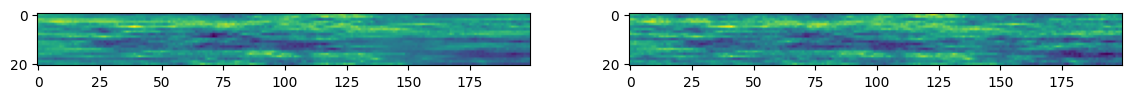

In [102]:
plt.figure(figsize=(14,14))
# sp1
plt.subplot(121)
plt.imshow(u[0, :,:200]) 
# sp2
plt.subplot(122)
plt.imshow(u_gauss[0, :,:200]) 

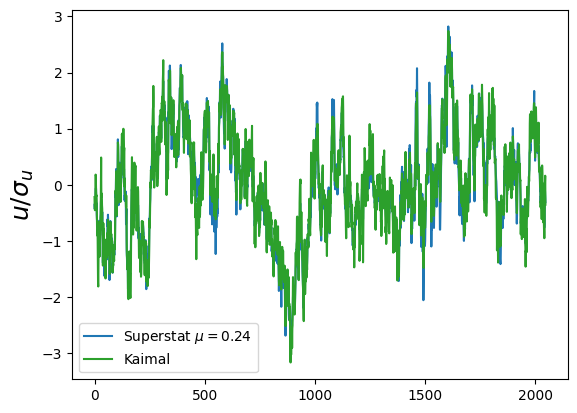

In [103]:
plt.plot(u[1,1, :], label='Superstat $\\mu=0.24$', color='C0')
plt.plot(u_gauss[1,1,:], label='Kaimal', color='C2')
#plt.plot(u_field[:1010,10,10], label='Gauss')
plt.legend()
plt.ylabel('$u/\\sigma_u$', fontsize=18)
plt.savefig('comparison_time_series.pdf')

# Statistical quantities (structure functions, spectra)

In [104]:
R_struc = np.logspace(0.2, 2.9, 20, dtype='int')
print(R_struc)
struc_2 = np.zeros(R_struc.size)
struc_4 = np.zeros(R_struc.size)
struc_2_gauss = np.zeros(R_struc.size)
struc_4_gauss = np.zeros(R_struc.size)
for rr in range(R_struc.size):
    struc_2[rr] = np.mean((np.roll(u, R_struc[rr], axis=2)-u)**2)
    struc_4[rr] = np.mean((np.roll(u, R_struc[rr], axis=2)-u)**4)
    struc_2_gauss[rr] = np.mean((np.roll(u_gauss, R_struc[rr], axis=2)-u_gauss)**2)
    struc_4_gauss[rr] = np.mean((np.roll(u_gauss, R_struc[rr], axis=2)-u_gauss)**4)

[  1   2   3   4   5   8  11  15  21  30  41  57  80 111 154 214 297 412
 572 794]


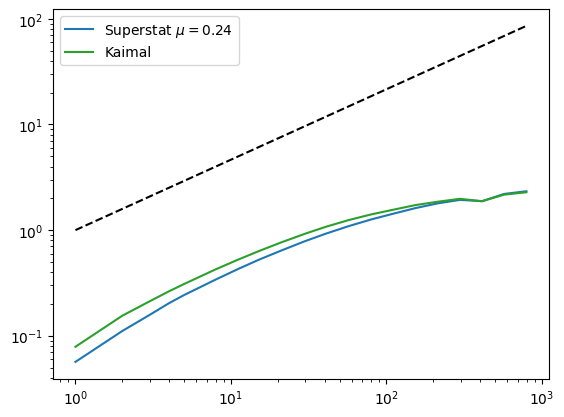

In [105]:
# second-order structure functions
plt.loglog(R_struc,struc_2, label='Superstat $\\mu=0.24$', color='C0')
plt.loglog(R_struc,struc_2_gauss, label='Kaimal', color='C2')
plt.loglog(R_struc,R_struc**(2/3.), color='black', ls='dashed')
plt.legend()

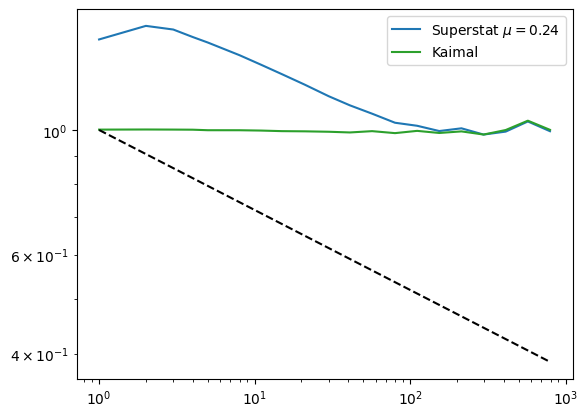

In [106]:
# flatness
plt.loglog(R_struc,struc_4/(3.*struc_2**2), label='Superstat $\\mu=0.24$', color='C0')
plt.loglog(R_struc,struc_4_gauss/(3.*struc_2_gauss**2), label='Kaimal', color='C2')
plt.loglog(R_struc, R_struc**(-4*mu/9), color='black', ls='dashed')
plt.legend()

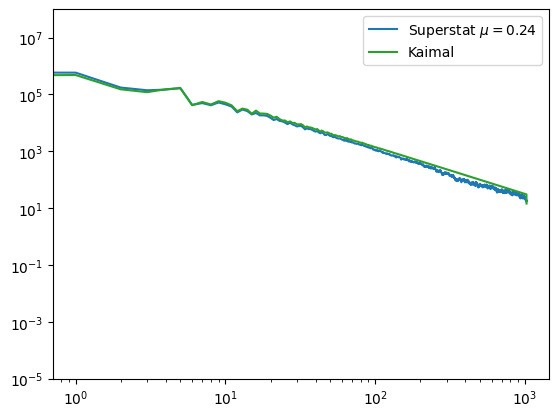

In [107]:
# spectra
u_hat = np.fft.rfft(u, axis=2)
u_hat_gauss = np.fft.rfft(u_gauss, axis=2)
spec = np.mean(np.abs(u_hat**2), axis=(0,1))
spec_gauss = np.mean(np.abs(u_hat_gauss**2), axis=(0,1))
plt.ylim(10**(-5), 10**(8))
plt.loglog(spec, label='Superstat $\\mu=0.24$', color='C0')
plt.loglog(spec_gauss, label='Kaimal', color='C2')
plt.legend()

# Increment Probability Density function

In [108]:
def inc_pdf(u, R_PDF, bins, u_max):
    pdf_inc = np.zeros((R_PDF.size, bins))
    std_inc = np.zeros(R_PDF.size)
    for rr in range(R_PDF.size):
        inc_x = np.roll(u,R_PDF[rr])[R_PDF[rr]:]-u[R_PDF[rr]:]
        pdf_inst_x, edges = np.histogram(inc_x, bins=bins, range=[-u_max,u_max])
        pdf_inc[rr] += pdf_inst_x
        std_inc[rr] += np.std(inc_x)
    return std_inc, pdf_inc

In [109]:
bins = 128
R_PDF = np.array([1, 3, 5, 15, 100])
u_max = 1.
std, pdf = inc_pdf(u/np.max(u), R_PDF, bins, u_max)
pdf = np.ma.masked_where(pdf ==0, pdf)
v_neu = np.linspace(-u_max, u_max, bins)

/opt/homebrew/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/homebrew/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


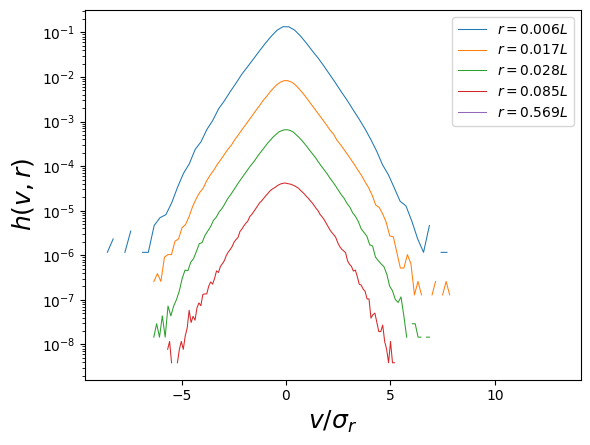

In [110]:
for rr in range(R_PDF.size):
    r = R_PDF[rr]*swf.dt*swf.V_hub
    plt.plot(v_neu/std[rr], pdf[rr]/np.sum(pdf[rr])*10**(-rr), label='$r= {0:.3f}$'.format(r/swf.L)+'$L$', lw = 0.75)
plt.yscale('log')
plt.xlabel('$v/\\sigma_r$', fontsize=18)
plt.ylabel('$h(v,r)$', fontsize=18)
plt.legend(frameon=True)